<a href="https://colab.research.google.com/github/VinaySingh561/tradingwebapp/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
69/69 [==============================] - 9s 59ms/step - loss: 0.0173
Epoch 2/10
69/69 [==============================] - 5s 75ms/step - loss: 0.0116
Epoch 3/10
69/69 [==============================] - 4s 60ms/step - loss: 0.0116
Epoch 4/10
69/69 [==============================] - 4s 65ms/step - loss: 0.0116
Epoch 5/10
69/69 [==============================] - 5s 69ms/step - loss: 0.0116
Epoch 6/10
69/69 [==============================] - 4s 61ms/step - loss: 0.0116
Epoch 7/10
69/69 [==============================] - 5s 73ms/step - loss: 0.0116
Epoch 8/10
69/69 [==============================] - 4s 62ms/step - loss: 0.0115
Epoch 9/10
69/69 [==============================] - 4s 61ms/step - loss: 0.0115
Epoch 10/10
69/69 [==============================] - 5s 77ms/step - loss: 0.0116


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


18/18 [==============================] - 1s 19ms/step


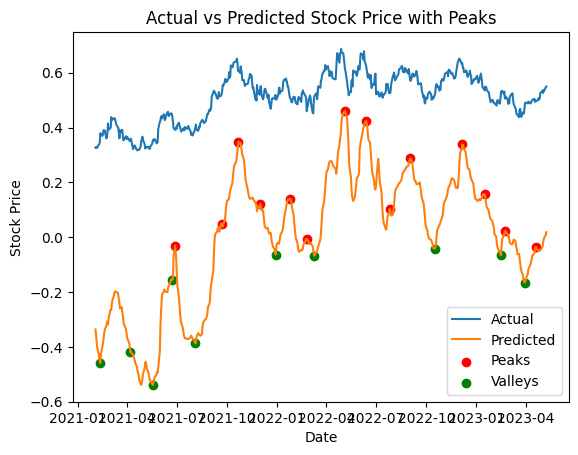

In [31]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
import peakutils

# Define the stock symbol and the desired date range
symbol = 'RELIANCE.NS'
start_date = '2012-01-01'
end_date = '2023-05-10'

# Fetch stock market data from Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

# Select the relevant features (e.g., 'Open', 'High', 'Low', 'Volume') and the target variable ('Close')
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
data_1 = data[features]

# Split the data into training and testing sets (80% for training, 20% for testing)
train_data, test_data = train_test_split(data_1, test_size=0.2, shuffle=False)

# Scale the data using Min-Max scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Create the training dataset
X_train, y_train = [], []
for i in range(60, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the testing dataset
inputs = data_1[len(data) - len(test_data) - 60:].values
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-60:i])

X_test = np.array(X_test)

# Make predictions on the test set
predictions_scaled = model.predict(X_test)



# Scaling
predictions_scaled = (predictions_scaled-predictions_scaled.mean())/(predictions_scaled.max()-predictions_scaled.min())
data[target] = (data[target]-data[target].mean())/(data[target].max()-data[target].min())


#Signal
# Find the indices of the peaks in the predictions_scaled array
peaks_indices = peakutils.indexes(predictions_scaled.flatten(), thres=0.5, min_dist=20)
valleys_indices = peakutils.indexes(-predictions_scaled.flatten(), thres=0.5, min_dist=20)
# Get the corresponding peak values
peaks_values = predictions_scaled.flatten()[peaks_indices]
valleys_values = predictions_scaled.flatten()[valleys_indices]

# Plot the actual and predicted values with peaks
data[target] = (data[target]-data[target].mean())/(data[target].max()-data[target].min())
plt.plot(data.index[-len(test_data):], data[target][-len(test_data):].values, label='Actual')
plt.plot(data.index[-len(test_data):], predictions_scaled, label='Predicted')
plt.scatter(data.index[-len(test_data):][peaks_indices], peaks_values, c='r', label='Peaks')
plt.scatter(data.index[-len(test_data):][valleys_indices], valleys_values, c='g', label='Valleys')
plt.xlabel('Date')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price with Peaks')
plt.legend()
plt.show()



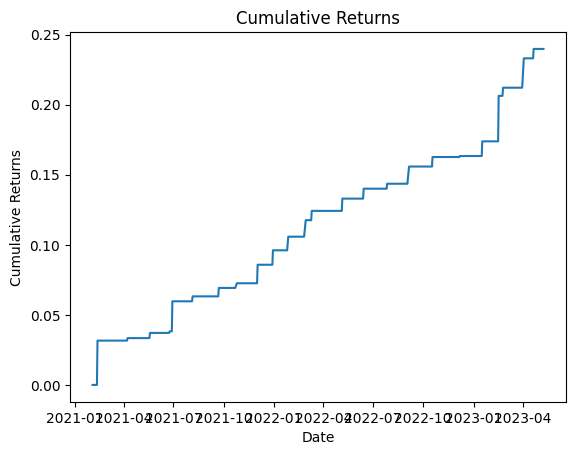

Sharpe ratio: 2.542139188509575
Returns: 63.240787506103516


In [32]:
# Generate signals for buying and selling based on peaks and valleys
signals = np.zeros_like(predictions_scaled.flatten())
signals[peaks_indices] = -1  # Sell signal at peaks
signals[valleys_indices] = 1  # Buy signal at valleys

# Calculate returns using signals and predicted values
returns = np.diff(predictions_scaled.flatten()) * signals[:-1]

# Calculate cumulative returns
cumulative_returns = np.cumsum(returns)

# Calculate Sharpe ratio
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

# Plot the cumulative returns
plt.plot(data.index[-len(test_data):][1:], cumulative_returns)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns')
plt.show()

print(f"Sharpe ratio: {sharpe_ratio}")
print(f"Returns: {cumulative_returns.sum()}")